# This notebook is supplementary to the GUI notebook. 

The purpose of this notebook is to illustrate the main hardware processing times to compare them to similar software applications. This notebook uses PYNQ for communication with the system generator design based on David Northcote's Sobel filter design:

<img src="assets/SystemGenModel.JPG", width = 500, height = 50>

The model ustilises five channels for user communication through JUpyter to control a range of filters and intensities, some as demonstrated throughout this notebook.

The bitstream was created using Vivado following the desing methodology presented in Tutorial 4, the IP can be seen below: 

<img src="assets/FullSystemIP.JPG", width = 400, height = 200>

## Handling images in Python

Using Craig Ramsay's Jupyter notebook example to create this notebook.

  1. `PIL` (Python Image Library) for most of the image handling
  2. `Numpy` for support for fast, statically-typed, fixed-length buffers. This is useful for performance when working with large images, but also for streaming these images to and from fixed-point hardware.
  
Several other libraries were included such as time, cv2 and scipy.interpolate to produce the desired software effects and also calculate processing times for the functions.

In [1]:
from PIL import Image
import time
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
%matplotlib inline

First reading the JPG file from the SD card.

In [2]:
image_raw = Image.open("assets/peppers.png")

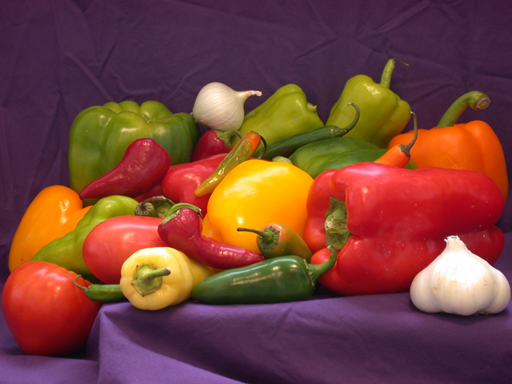

In [3]:
image_raw

## Formatting the image for hardware

The system created for this design expects the image to:

  * The image should be 320*240 pixels
  * Each pixel should be 32 bits
    + 8 bits for red
    + 8 bits for green
    + 8 bits for blue
    + and the remaining 8 bits are unused --- they are only there to pad the pixel out to 32 bits (the natural width of the AXI interface we're using between the PS and PL)
  * The image should then be padded to have one extra pixel all the way around the image's circumference. This is to allow local filtering to be done all the way to the extremes of the original image. (Curtousy of Craig Ramsay's notebook example for this useful information).

In [4]:
IMG_SIZE = (320,240) 

# Resize and force to RGB colours
image = image_raw.resize(IMG_SIZE).convert('RGB')

# Interpret as a 3D array of bytes (uint8)
image_array = np.array(image, dtype=np.uint8)

# Add extra padding on the X and Y dimensions
image_array_padded = np.pad(image_array, ((1,1),(1,1),(0,0)), 'symmetric')

Re-display the image.

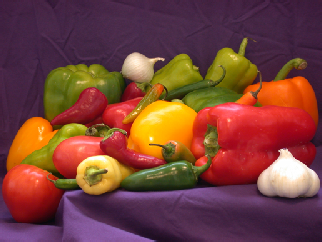

In [5]:
Image.fromarray(image_array_padded, 'RGB')

## Split the image into colour components.

As the system we have developed applies filters to colour images, we take the seperate colour channels and perform the operations on them individually. Once the processing has occured the image is concatinated through hardware, however, due to differences in image display between Vivado and Jupyter/Python the image has to be seperated and concatenated through software again to apply the correct effect to the correct colour channel. This is achieved later in the notebook.

In [6]:
red_images = image_array_padded[:,:,0]
blue_images = image_array_padded[:,:,2]
green_images = image_array_padded[:,:,1]

rbg = np.dstack((green_images, blue_images, red_images))  # stacks 3 h x w arrays -> h x w x 3

## Communication with filters.

Reserve the buffers of the correct size for one input image (with padding) and one output (without padding).
We model the input image as a 3 dimensional array again, but this time we expand the last dimension from a size of 3 (R, G, or B) to 4. This introduces a space for the 8 bit padding required to ensure every pixel aligns to 32 bit boundaries.

As our filter is working on a colour image we have to include a 3D array for the output buffer. 

In [7]:
from pynq import Overlay
from pynq import Xlnk

overlay = Overlay("bitstream/design_1_wrapper.bit")

In [8]:
#overlay?

In [9]:
dma = overlay.axi_dma

In [10]:
# Make an Xlnk instance to control memory allocation
xlnk = Xlnk()

# Input array for DMA use
in_dma_array  = xlnk.cma_array(shape=(IMG_SIZE[1]+2, IMG_SIZE[0]+2, 4), dtype=np.uint8)

# Output array for DMA use
out_dma_array = xlnk.cma_array(shape=(IMG_SIZE[1],IMG_SIZE[0],4), dtype=np.uint8)

## Define a filter function.

Let's define a function to take an image (as a numpy array) and then return the image that has been processed by the PL.

We have five AXI (memory mapped) registers that can be written to, the controls for these are as follows: 

* `LUTSelect`, This parameter will choose which LUT to apply to the image. 0(negative), 1(warming), 2(cooling), 3(brightning), 4(dimming), 5(no LUT).
* `Reference`, This is the value used to compare the users choices to control logic flow.
* `BlurSelect`, A value of greater than 127 here will cause the logic to select that Blur/Sharpen is requested.
* `BlurOrSharpen`, A value of greater than 127 here will cause the logic to Sharpen the Image else blur. (Only hapens if the NoBlurSelection is greater than 127.)
* `LUTIntensity`, This parameter will choose the intensity of the applied LUT. Range Low-High, 0-4.
    
We'll need to copy the image array into one of the DMA buffers we have allocated above before streaming it. Then we can use PYNQ's DMA transfer(..) and wait(...) functions to stream data to and from the filter IP. 

In [11]:
#Effect Controls in System Generator Model

def effect(image_array, BlurOrSharpen, reference, BlurSelect, LUTSelect, LUTIntensity):
    
    #Set system parameters
    overlay.fullsystembuild_0.write(0x00, LUTSelect)    #LUT Selection
    overlay.fullsystembuild_0.write(0x04, reference)  #reference  
    overlay.fullsystembuild_0.write(0x08, BlurSelect)  #Blur/Sharp Request
    overlay.fullsystembuild_0.write(0x0c, BlurOrSharpen)  #Blur or Sharp
    overlay.fullsystembuild_0.write(0x10, LUTIntensity)    #LUT Intensity
    
    # Copy image array into dma buffer
    in_dma_array[:, :, :3]= image_array[:, :, :3]
    
    # Perform DMA transfers in both directions
    dma.recvchannel.transfer(out_dma_array)
    dma.sendchannel.transfer(in_dma_array)
    dma.sendchannel.wait()
    dma.recvchannel.wait()
    
    # Return processed image array from PL 
    return out_dma_array

# Now we want to compare hardware against software processing times.

## Hardware LUT Filter

This section of the notebook will compare a hardware and software implementation of blurring with the hardware model. 
The hardware convolution kernel used for blurring was:

<img src="assets/LUTCoolBlock.JPG", width = 500, height = 100>

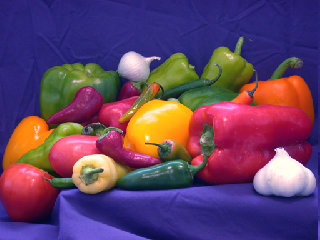

In [12]:
#We can input the user choices here for any 
#desired effect the system can provide using the effect() function:
hLUThstart = time.clock()
image_output = effect(rbg, 120 ,127, 120, 2 ,2)
hLUThend = time.clock()
hLUThtime = hLUThend - hLUThstart
hLUThtime

red_output = image_output[:,:,2]
blue_output = image_output[:,:,1]
green_output = image_output[:,:,0]

rgb = np.dstack((red_output, green_output, blue_output))
Image.fromarray(rgb[:,:,:3], mode='RGB')

In [13]:
hLUThtime

0.04313799999999901

## Software LUT Filtering


The LUT processing could also be carried out exclusively in software environment. This follows the guidelines that are set out in the Questions document submitted by the group. The example below represents an example of the cold filter, with the red channel's intensity reduced and blue channel's intensity increased. As a reminder, the other filters are designed as follows:

* `warm filter `, red channel's intensity increased, blue channel's intensity decreased.
* `bright filter `, all channels' intensities increased.
* `dim filter `, all channel's intensities decreased.

In [14]:
def spreadLookupTable(x, y):
    spline = UnivariateSpline(x, y)
  
    return spline(range(256))

In [15]:
def coldImage(image):
    increaseLookupTable = spreadLookupTable([0, 64, 128, 255], [0, 100, 180, 255])
    decreaseLookupTable = spreadLookupTable([0, 64, 128, 255], [0, 30, 80, 255])
    red_channel, green_channel, blue_channel = cv2.split(image)
    red_channel = cv2.LUT(red_channel, decreaseLookupTable).astype(np.uint8)
    blue_channel = cv2.LUT(blue_channel, increaseLookupTable).astype(np.uint8)
    return cv2.merge((red_channel, green_channel, blue_channel))

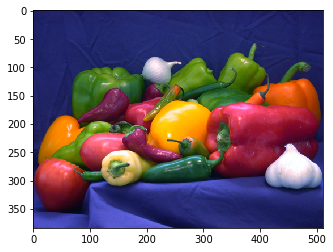

In [16]:
img = cv2.imread('assets/peppers.png')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

sLUTsstart = time.clock()
colderimage = coldImage(img)
sLUTsend = time.clock()
sLUTstime = sLUTsend - sLUTsstart


plt.imshow(colderimage)

In [17]:
sLUTstime

0.03951200000000199

## Hardware Blur Filtering

This section of the notebook will compare a hardware and software implementation of blurring with the hardware model. 
The hardware convolution kernel used for blurring was:

<img src="assets/HardwareBlurKernel.JPG", width = 200, height = 100>

and is equivalent to: 

<img src="assets/KernelBlur.JPG", width = 100, height = 100>

In [18]:
# Hardware blur timeing
hblurstart = time.clock()
blurred_image = effect(rbg, 120, 127, 130, 4, 0)
hblurend = time.clock()
hblurtime = hblurend - hblurstart
hblurtime

0.04502000000000095

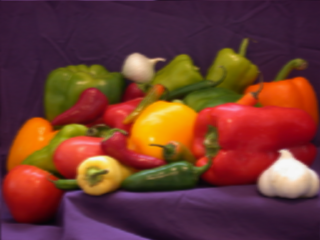

In [19]:
# Display hardware blurred image 
red_blur = blurred_image[:,:,2]
blue_blur = blurred_image[:,:,1]
green_blur = blurred_image[:,:,0]

blurrgb = np.dstack((red_blur, green_blur, blue_blur))
Image.fromarray(blurrgb[:,:,:3], mode='RGB')

# Software Blur Filtering (CV2)

The same kernel as shown above was applied through the use of cv2.

In [20]:
img = cv2.imread('assets/peppers.png')

img2 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

In [21]:
rows,cols = img.shape[:2]
def blur(img2):
    kernel_3x3 = np.ones((3,3),np.float32) / 9.0
    output=cv2.filter2D(img2,-1,kernel_3x3)
    output2 = cv2.filter2D(output,-1,kernel_3x3) 
    return output2

In [22]:
#Software blur timeing
sblurstart = time.clock()
blurred_image = blur(img2)
sblurend = time.clock()
sblurtime = sblurend - sblurstart
sblurtime

0.13971400000000145

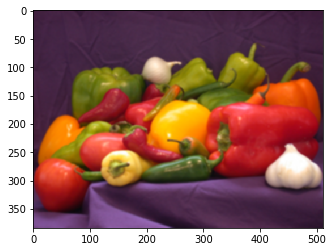

In [23]:
#Display Software blurred image
plt.imshow(blurred_image)

## Blur Filter Time comparison

From the timing values shown after the processing we can see that the harware is faster than the software for applying these convolution filters.

## Hardware Sharp Filtering

This section of the notebook will compare a hardware and software implementation of sharpening with the hardware model. 
The hardware convolution kernel used for blurring was:

<img src="assets/HardwareSharpKernel.JPG", width = 200, height = 100>

and is equivalent to: 

<img src="assets/KernelSharp.JPG", width = 100, height = 100>

In [24]:
#sharp timing
hsharpstart = time.clock()
sharp_image = effect(rbg, 130, 127, 130, 4, 0)
hsharpend = time.clock()
hsharptime = hsharpend - hsharpstart
hsharptime

0.04579000000000022

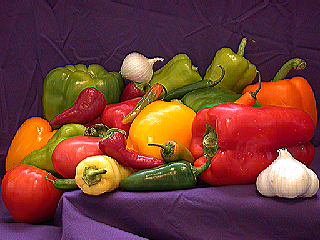

In [25]:
red_sharp = sharp_image[:,:,2]
blue_sharp = sharp_image[:,:,1]
green_sharp = sharp_image[:,:,0]

sharprgb = np.dstack((red_sharp, green_sharp, blue_sharp))
Image.fromarray(sharprgb[:,:,:3], mode='RGB')

# Software Sharp Filtering

In [26]:
def sharp(img2):
    kernel_sharpen_1 = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
    output1=cv2.filter2D(img2,-1,kernel_sharpen_1) 
    return output1

In [27]:
ssharpstart = time.clock()
sharp_image = sharp(img2)
ssharpend = time.clock()
ssharptime = ssharpend - ssharpstart
ssharptime

0.04827500000000029

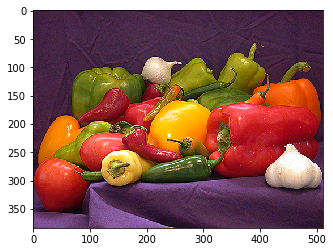

In [28]:
plt.imshow(sharp_image)

## Sharp Filter Time comparison

From the timing values shown after the processing we can see that the harware is faster than the software for applying these convolution filters.

# Histogram Equalisation

The group also attempted to perform histogram equalisation in order to increase the contrast of an image. Although the design was never implemented in hardware, the group found it worthwhile to include the software design of this process, which included the LUT processing. The idea was to use RAM blocks instead of ROM for the hardware design in order to dynamically change the contents of the hardware LUT's.

In [29]:
## Obtaining, converting and obtaining characteristics of the image
img = cv2.imread('assets/peppers.png')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
r,g,b = cv2.split(img)
height, width, channels = img.shape

In [30]:
## Obtaining histogram
hist = [0] * 256

for x in range(0,width):
    for y in range(0, height):
        hist[b[y,x]] =hist[b[y,x]] + 1

for x in range(0,width):
    for y in range(0, height):
        hist[g[y,x]] =hist[g[y,x]] + 1

for x in range(0,width):
    for y in range(0, height):
        hist[r[y,x]] =hist[r[y,x]] + 1

In [31]:
## Obtaining original CDF
cdf = [0] * 256

cdf[0] = hist[0]

for x in range(1,255):
    cdf[x] = cdf[x-1]+hist[x]

In [32]:
## Obtaining equalised CDF to provide input for LUT processing
cdf_eq = [0] * 256

cdf_min = min(cdf)

for x in range(0,255):
    cdf_eq[x] = round((cdf[x]-cdf_min)/((width*height)-cdf_min)*255)

    cdf_eq[x] = round((cdf[x]-cdf_min)/((width*height)-cdf_min)*255)

cdf_eq[255] = 255

## Scaling the CDF to 256 values
cdf_eq_min = min(cdf_eq)
cdf_eq_max = max(cdf_eq)

for x in range(0,255):
    cdf_eq[x] = 255 * ((cdf_eq[x]-cdf_eq_min) / (cdf_eq_max-cdf_eq_min))

## Contrast enhancement
r_new = cv2.LUT(r, np.asarray(cdf_eq, dtype=np.float32)).astype(np.uint8)
b_new = cv2.LUT(b, np.asarray(cdf_eq, dtype=np.float32)).astype(np.uint8)
g_new = cv2.LUT(g, np.asarray(cdf_eq, dtype=np.float32)).astype(np.uint8)

Since all channels have now been contrasted, they could be merged to form the final image which can be displayed below.

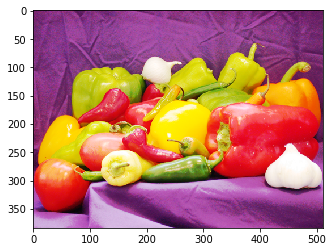

In [33]:
contrasted_image = cv2.merge((r_new, g_new, b_new))

plt.imshow(contrasted_image)